# Computational Time Analysis

In this notebook we explore the effects of different model configurations on training time and model throughput. Forest mortality forecasting happens at an annual cadence, so computational time is not of great concern for this particular project. **We have already documented the training time of many model architectures in our AutoML notebook.** This analysis will only consider XGBoost and K nearest neighbors because there were the best-performing models in the AutoML notebook.

## Get data

In [1]:
from google.cloud.storage import Client
import pandas as pd
import random

client = Client(project="forest-lst")
bucket = "preisler_tfdata"

records = [
    "/".join(["gs://{}".format(bucket), f.name])
    for f in client.list_blobs(bucket, prefix="preisler-rectangular")
    if f.name.endswith("csv") and not "v2" in f.name
]

random.shuffle(records)

ds = pd.concat((pd.read_csv(f).drop(["system:index", ".geo"], axis=1) for f in records), ignore_index=True)
ds.describe()

,fire,latitude,longitude,near,pct_mortality,prcp1,prcp2,prcp3,prcp4,rhost,winter_tmin,year
count,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000,363674.000000
mean,0.035538,38.729241,-120.921110,0.094709,0.036693,890.274912,904.502043,917.400381,927.187582,0.618464,-9.314954,2011.968381
std,0.164201,2.360971,1.895034,0.188841,0.116157,562.968146,569.931336,546.741807,551.616143,0.396780,6.412776,6.140651
min,0.000000,32.567223,-124.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-41.880527,2000.000000
25%,0.000000,37.135424,-122.548171,0.000000,0.000000,456.426167,469.380201,490.736208,493.392910,0.155901,-14.085734,2007.000000
50%,0.000000,39.169638,-120.967136,0.004400,0.000000,768.615228,778.353022,805.471707,815.382320,0.810296,-8.277435,2012.000000
75%,0.000000,40.739544,-119.565764,0.088000,0.004800,1208.003686,1225.228910,1248.191184,1268.501649,0.973267,-3.930672,2017.000000
max,2.000000,42.006813,-116.152166,1.000000,1.000000,4795.203592,4795.203592,3900.853290,4054.331371,1.000000,4.194588,2023.000000


Since we are interested in computation time, not model accuracy, we omit the usual test-train split. Since KNN is sensitive to the scale of input parameters, we still standardize data like before.

In [2]:
def standardize(arr):
    return (arr - arr.mean()) / arr.std()

X = ds.drop(["pct_mortality"], axis=1).apply(standardize).to_numpy()
y = ds["pct_mortality"].to_numpy()

## KNN: Number of neighbors

The main hyperparameter in the K neighbors regressor is the number of neighbors. How does changing its value affect training time and throughput?

In [3]:
import timeit
import xgboost as xgb
from sklearn.neighbors import KNeighborsRegressor

In [4]:
ks = [2, 4, 6, 8, 10] # default: 5
train_times = []
predict_times = []
for k in ks:
    print(k)
    knn = KNeighborsRegressor(n_neighbors=k)
    train_times.append(timeit.timeit(lambda: knn.fit(X, y), number=5))
    predict_times.append(timeit.timeit(lambda: knn.predict(X), number=1))

2
4
6
8
10


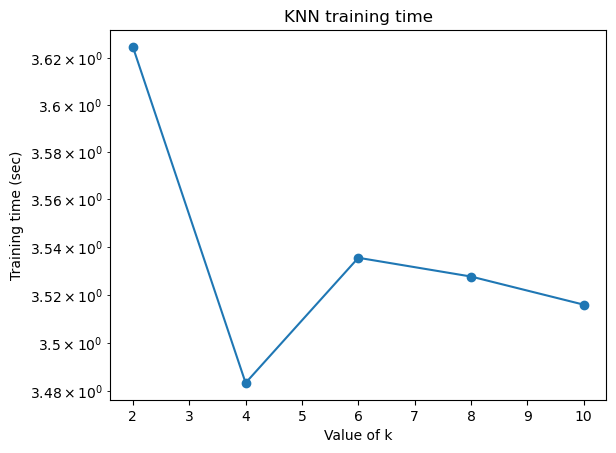

In [5]:
from matplotlib import pyplot as plt

plt.plot(ks, train_times)
plt.scatter(ks, train_times)
plt.yscale("log")
plt.ylabel("Training time (sec)")
plt.xlabel("Value of k")
plt.title("KNN training time")
plt.show()

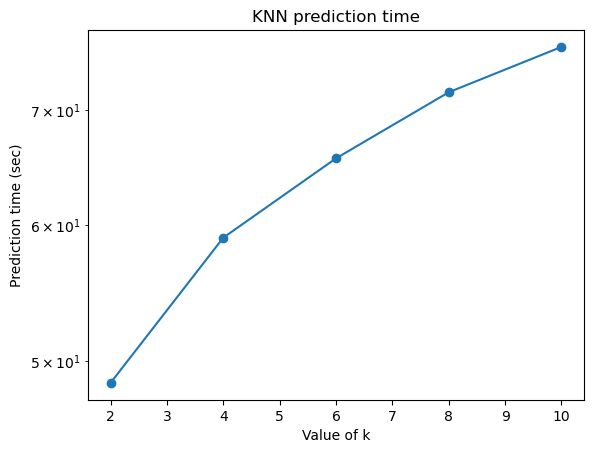

In [6]:
plt.plot(ks, predict_times)
plt.scatter(ks, predict_times)
plt.yscale("log")
plt.ylabel("Prediction time (sec)")
plt.xlabel("Value of k")
plt.title("KNN prediction time")
plt.show()

The value of K does not seem to affect training time, but has a moderate effect on prediction time.

## XGBoost: regularization $\alpha$ and $\lambda$

Tree-based algorithms often include hyperparameters that control tree depth, leaf node size, etc. These are difficult to interpret in the context of the data. Instead, we can look at the regularization parameters $\alpha$ and $\lambda$. These indirectly affect tree complexity by modifying the loss function used to stop tree growth.

In [7]:
import numpy as np
from tqdm import tqdm

alphas  = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
lambdas = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])

input_params = np.array(np.meshgrid(alphas, lambdas)).T.reshape(-1,2)

xgb_train_times   = []
xgb_predict_times = []
for i in tqdm(range(input_params.shape[0])):
    this_a = input_params[i, 0]
    this_l = input_params[i, 1]
    this_xgb = xgb.XGBRegressor(reg_alpha=this_a, reg_lambda=this_l)
    xgb_train_times.append(timeit.timeit(lambda: this_xgb.fit(X, y), number=1))
    xgb_predict_times.append(timeit.timeit(lambda: this_xgb.predict(X), number=1))

100%|██████████| 36/36 [01:06<00:00,  1.83s/it]


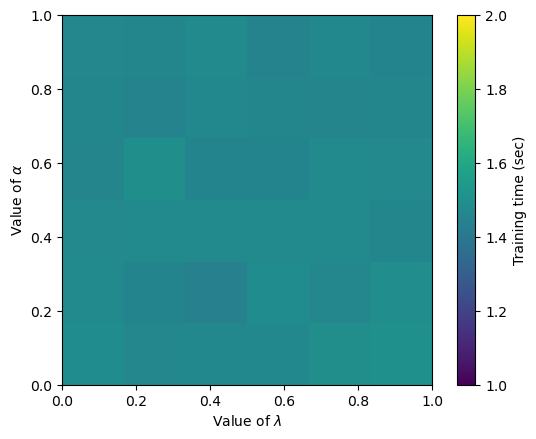

In [17]:
plt.imshow(np.array(xgb_train_times).reshape((6, 6)), extent=[0, 1, 0, 1], vmin=1, vmax=2)
plt.ylabel(r"Value of $\alpha$")
plt.xlabel(r"Value of $\lambda$")
cb = plt.colorbar()
cb.set_label("Training time (sec)")
plt.show()

Manipulating regularization does not seem to affect training time much. This could result from the fact that our response variable has strong positive skew, so changes in the loss function are dominated by error in a small number of extreme mortality events instead of model complexity. A more likely candidate for affecting training time and throughput is the number of trees in a model. How does this parameter affect training time, throughput, and accuracy?

In [25]:
n_trees = 100 * np.arange(1, 10) # default = 100

In [31]:
from sklearn.metrics import root_mean_squared_error

train_time_ntree = []
predict_time_ntree = []
score_ntree = []

for i in tqdm(n_trees):
    this_xgb = xgb.XGBRegressor(n_estimators=i)
    train_time_ntree.append(timeit.timeit(lambda: this_xgb.fit(X, y), number=1))
    predict_time_ntree.append(timeit.timeit(lambda: this_xgb.predict(X), number=1))
    score_ntree.append(root_mean_squared_error(y, this_xgb.predict(X)))

100%|██████████| 9/9 [01:21<00:00,  9.08s/it]


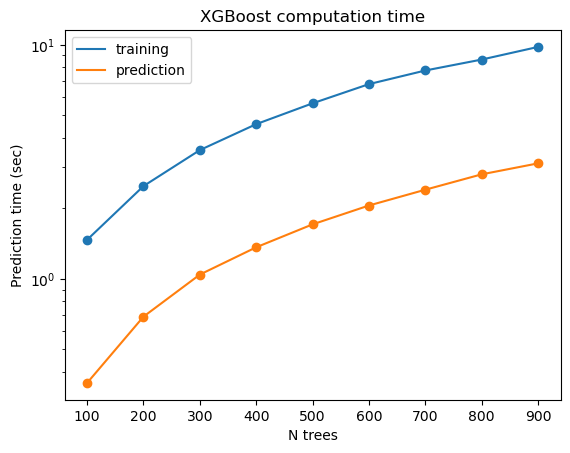

In [32]:
plt.plot(n_trees, train_time_ntree, label="training")
plt.plot(n_trees, predict_time_ntree, label="prediction")
plt.scatter(n_trees, train_time_ntree)
plt.scatter(n_trees, predict_time_ntree)
plt.yscale("log")
plt.ylabel("Prediction time (sec)")
plt.xlabel("N trees")
plt.title("XGBoost computation time")
plt.legend()
plt.show()

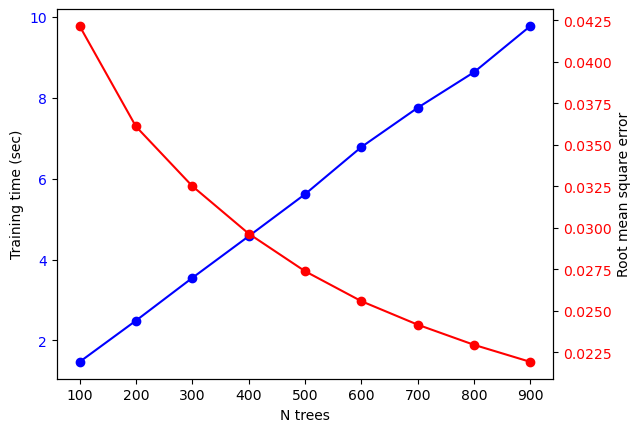

In [38]:
fig, ax1 = plt.subplots()

c1 = "blue"
c2 = "red"

ax1.plot(n_trees, train_time_ntree, label="training", color=c1)
ax1.scatter(n_trees, train_time_ntree, color=c1)
ax1.set_xlabel("N trees")
ax1.set_ylabel("Training time (sec)")
ax1.tick_params(axis="y", labelcolor=c1)

ax2 = ax1.twinx()
ax2.plot(n_trees, score_ntree, label="accuracy", color=c2)
ax2.scatter(n_trees, score_ntree, color=c2)
ax2.set_ylabel("Root mean square error")
ax2.tick_params(axis="y", labelcolor=c2)

plt.show()

Here we find that training time increases linearly with the number of trees in the model. This makes sense given that in XGBoost, the number of estimators is equivalent to the number of boosting rounds. Each boosting round is the same procedure, so the execution time would be expected to grow linearly. Adding more trees also increases model complexity and resulted in a decreased root mean square error. This offers some insight for making an operational version of this model: the default `n_estimator` value of 100 is too small to fully capture the complexity of the input dataset. We do not know if the more complex model is overfitted because we did not do cross-validation in this exercise.

## Discussion: real-world application

Forest mortality risk maps are generally completed once per year because the ecological processes that kill trees undergo annual cycles. Winter climate drives boring insect reproduction while summer climate drives water stress. Therefore rapid prediction is not necessary for this model to be successful. With XGBoost, none of our experiments above took longer than a minute to fit on the entire training dataset. Prediction time was less than the training time. KNN was much slower, both during training and prediction. XGBoost offers us better computational speed and accuracy for a real-world application.